In [15]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP_sklearn

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = ToyGraspDataset(root='data', size=1200)
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

dataset2 = ToyGraspDataset(root='data', size=1200)
data2 = dataset2.data
pos_masks2 = data2[:,2] == 1
neg_masks2 = ~pos_masks2
# handle_masks = data[:,3] == 1

In [3]:
# load pos vs neg classifier
f = ClassifierNN([2, 64, 64, 1])
f, info = load_model_info('pos_vs_neg', f)
f = f.to(device)

0.0 0.999619


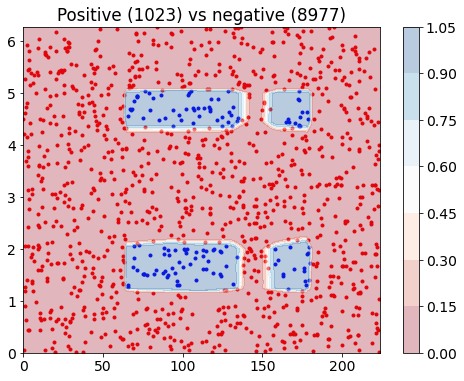

In [4]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)

ax.set_title(f'Positive ({int(info["pos_samples_size"])}) vs negative ({int(info["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

-7.8725634 568.2994


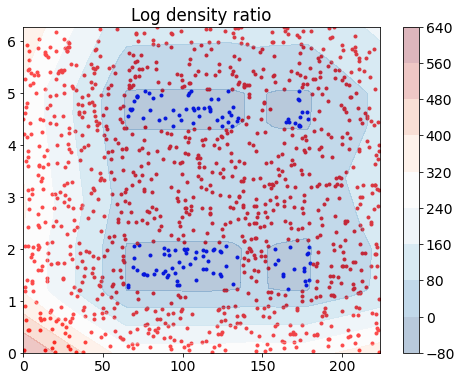

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05)

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [6]:
# refine samples
my_sample = torch.FloatTensor([[25, 0.3],
                               [210, 3]])#[160, 3]
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

In [7]:
steps_refinement = 100
# print(info['pos_samples_size'], info['neg_samples_size'])
# print(f)
# print(my_sample)
all_x1, all_v1 = refine_sample(my_sample.to(device), f, steps=steps_refinement,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-0.8971407 64.7622


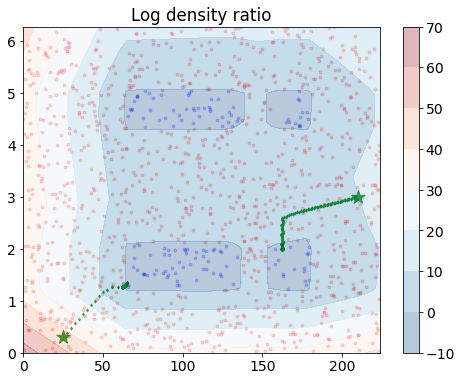

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)

Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                      Np=info['neg_samples_size'], Nq=info['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Sim+ vs Real+

In [9]:
# load pos vs neg classifier
# f2 = ClassifierNN([2, 32, 1])
f2 = ClassifierNN([2, 64, 64, 1])
f2, info2 = load_model_info('simvsreal', f2)
f2 = f2.to(device)
print(info.keys())
print(info2['pos_samples_size'], info2['neg_samples_size'])



# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']






dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'pos_samples_size', 'neg_samples_size'])
1053.0 3947.0


0.0 0.99900776


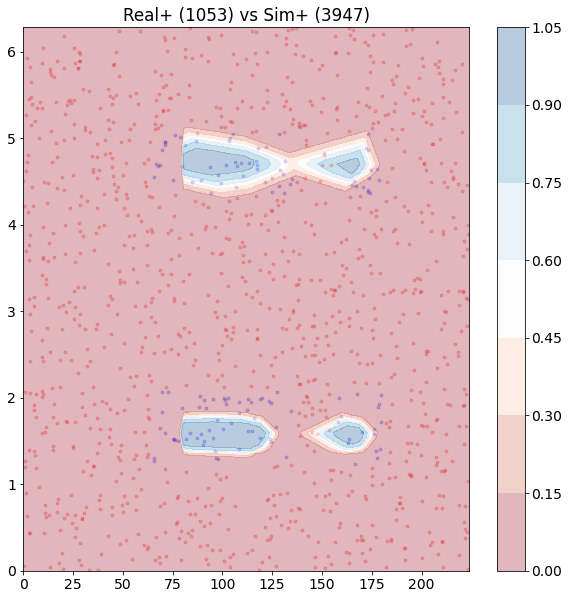

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(10,10))
# ax.scatter(data[handle_masks][:,0], data[handle_masks][:,1], marker='.', alpha=1.0, color='b')
# ax.scatter(data[~handle_masks][:,0], data[~handle_masks][:,1], marker='.', alpha=1.0, color='r')
ax.scatter(data2[pos_masks2][:,0], data2[pos_masks2][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data2[neg_masks2][:,0], data2[neg_masks2][:,1], marker='.', alpha=0.2, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)




ax.set_title(f'Real+ ({int(info2["pos_samples_size"])}) vs Sim+ ({int(info2["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

### SIM VS REAL GP

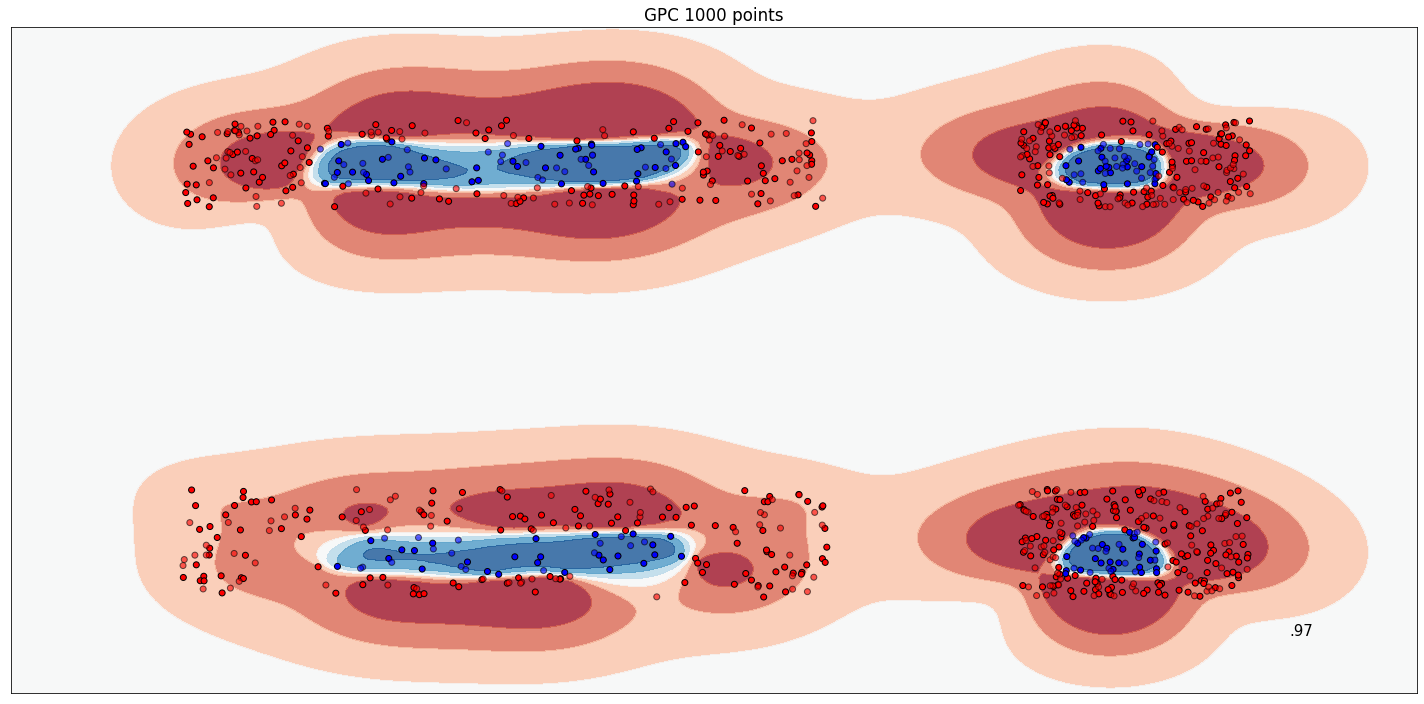

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# USING 2D FORK DATA ===============================
train_dataset = ToyGraspDataset(root='data', name='train_data', size=1000, is_pos_label=True, device=device, dataset='sim2real')
X = train_dataset.data[:,:2]
y = train_dataset.data[:,2].astype(int)
fork_1000 = (X,y)

h = .02  # step size in the mesh

figure = plt.figure(figsize=(20, 10))
# i = 1
# iterate over datasets
# for ds_cnt, ds in enumerate(datasets):
     # preprocess dataset, split into training and test part
#     X, y = ds
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
name = "GPC 1000 points"
clf = GaussianProcessClassifier(1.0 * RBF(1.0))
    
ax = plt.subplot(1,1,1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     else:
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title(name)
ax.set_title(name)
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
        size=15, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [12]:
Nq = np.sum(y)
Np = X.shape[0] - Nq
f2 = clf

In [19]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

all_x1, all_v1 = refine_sample_GP_sklearn(my_sample.to(device), f2, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = Nq, Np = Np)

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

AttributeError: 'GaussianProcessClassifier' object has no attribute 'eval'

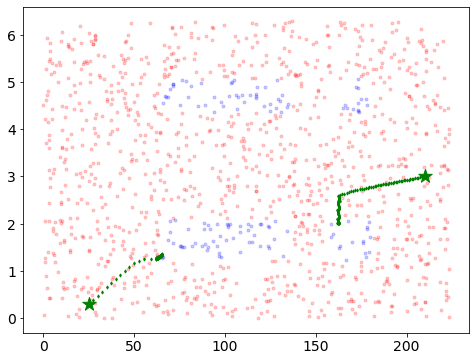

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
# ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')
ax.scatter(data2[pos_masks2][:,0], data2[pos_masks2][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data2[neg_masks2][:,0], data2[neg_masks2][:,1], marker='.', alpha=0.2, color='r')
plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)


Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np=Np, Nq=Nq)

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

### Multiple classifiers

In [75]:
steps_refinement = 100
all_x8, all_v8 = refine_sample2(my_sample.to(device), f, f2,
                                steps=steps_refinement,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
all_x8 = torch.cat(all_x8).numpy()

  0%|          | 0/100 [00:00<?, ?it/s]

In [76]:
# Np1=info['neg_samples_size'],
#                                 Nq1=info['pos_samples_size'],
#                                 Np2=info2['neg_samples_size'],
#                                 Nq2=info2['pos_samples_size']

-11.699127 110645.01


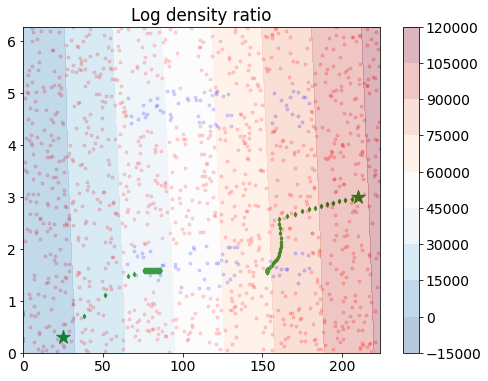

In [77]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# for i in range(1, steps_refinement, 1):
plt.scatter(all_x8[:,0]*224, all_x8[:,1]*(2*3.14), marker='d', color='g', s=10)

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [78]:
item = load_item('fork')

In [79]:
# from matplotlib.patches import ArrowStyle
from matplotlib import animation
# arrow_style = ArrowStyle("Simple", head_length=.6, head_width=1.0, tail_width=.1)
from matplotlib.patches import Arrow

In [18]:
%matplotlib notebook

In [19]:
sample_stream = all_x8[1::2]

<IPython.core.display.Javascript object>


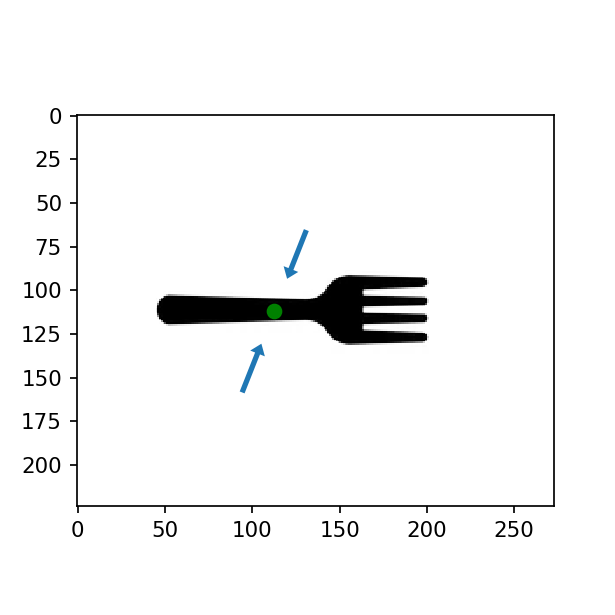

In [20]:
# def animate_grasp(sample_stream, fname):
fname = 'bad_to_pos_handle'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()

In [21]:
sample_stream = all_x8[::2]

<IPython.core.display.Javascript object>


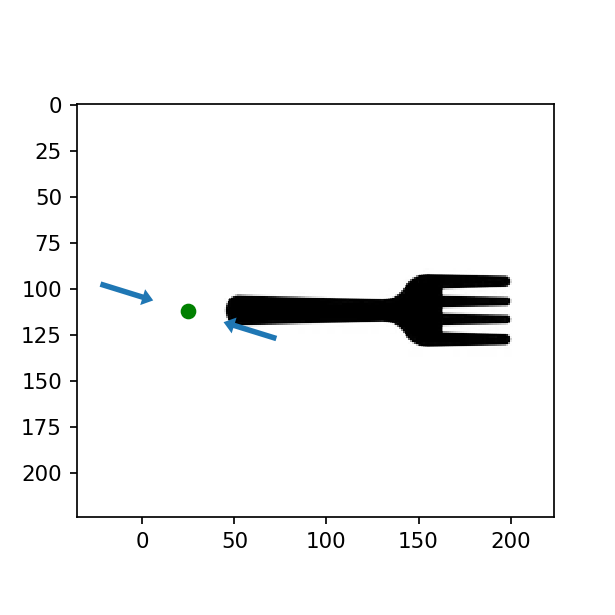

In [22]:
# def animate_grasp(sample_stream, fname):
fname = 'neg_to_pos'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()

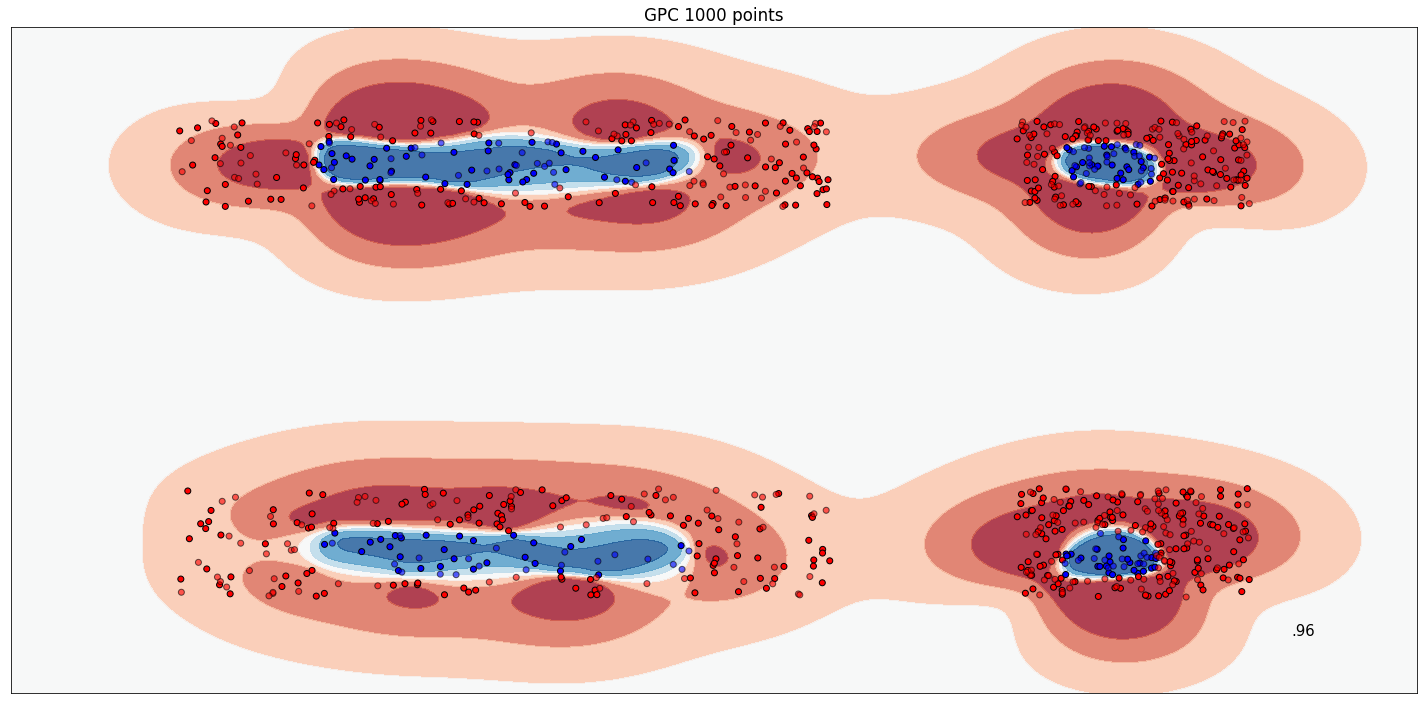

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# USING 2D FORK DATA ===============================
train_dataset = ToyGraspDataset(root='data', name='train_data', size=1000, is_pos_label=True, device=device, dataset='sim2real')
X = train_dataset.data[:,:2]
y = train_dataset.data[:,2].astype(int)
fork_1000 = (X,y)

h = .02  # step size in the mesh

figure = plt.figure(figsize=(20, 10))
# i = 1
# iterate over datasets
# for ds_cnt, ds in enumerate(datasets):
     # preprocess dataset, split into training and test part
#     X, y = ds
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
name = "GPC 1000 points"
clf = GaussianProcessClassifier(1.0 * RBF(1.0))
    
ax = plt.subplot(1,1,1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     else:
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title(name)
ax.set_title(name)
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
        size=15, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [29]:
Z

array([[0.49998108, 0.49997637, 0.49997061, ..., 0.50000208, 0.50000208,
        0.50000175],
       [0.49997614, 0.49997018, 0.4999629 , ..., 0.50000294, 0.50000263,
        0.50000205],
       [0.49997012, 0.49996265, 0.49995352, ..., 0.50000358, 0.50000292,
        0.50000206],
       ...,
       [0.49999884, 0.49999883, 0.49999898, ..., 0.49990774, 0.49992894,
        0.49994559],
       [0.49999966, 0.49999987, 0.50000028, ..., 0.49993099, 0.49994698,
        0.49995949],
       [0.50000017, 0.50000049, 0.50000103, ..., 0.49994872, 0.49996071,
        0.49997004]])